In [1]:
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
import seaborn as sns


az.style.use('arviz-darkgrid')

In [2]:
WAFFLE_DATA = 'waffle_divorce.csv'
DATA_FOLDER = '../../data'

In [3]:
df_waf = pd.read_csv(f'{DATA_FOLDER}/{WAFFLE_DATA}')
df_waf.head()

,Unnamed: 0,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage.SE,Divorce,Divorce.SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,1,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,2,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,3,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,4,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,5,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


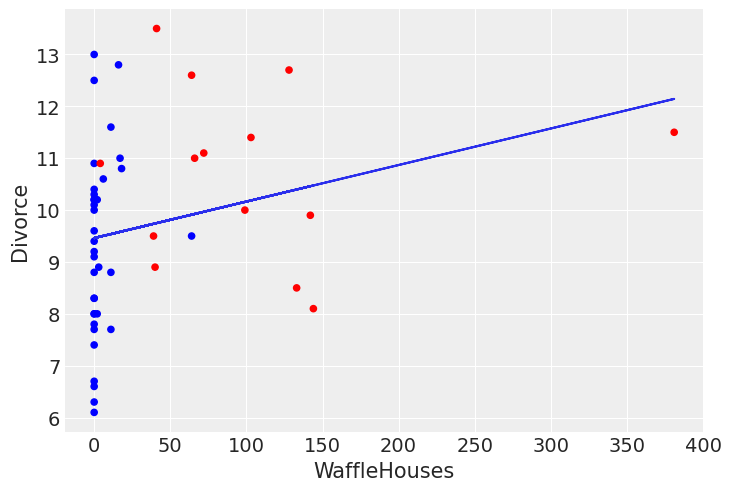

In [4]:
x = df_waf['WaffleHouses']
y = df_waf['Divorce']

colors = df_waf['South'].apply(lambda x: 'r' if x == 1 else 'b')

# Fit the data to a line using polyfit
m, c = np.polyfit(x, y, 1)

# Plot both the line and the original data
_, ax = plt.subplots(1, 1)
ax.plot(x, m * x + c)

df_waf.plot.scatter(x='WaffleHouses', y='Divorce', marker='o', c=colors, ax=ax)

plt.show()

### Code 5.1 Standardize Variables

In [5]:
age = (df_waf['MedianAgeMarriage'] - df_waf['MedianAgeMarriage'].mean()) / df_waf['MedianAgeMarriage'].std()
divorce = (df_waf['Divorce'] - df_waf['Divorce'].mean()) / df_waf['Divorce'].std()
marriage = (df_waf['Marriage'] - df_waf['Marriage'].mean()) /df_waf['Marriage'].std()

## The Model: Divorce Rate vs Median Age

$$
\begin{align*}
    D_i     & \sim N(\mu_i, \sigma) \\
    \mu_i   & \sim \alpha + \beta_A \cdot A_i \\
    \alpha  & \sim N(0, 0.2) \\
    \beta_A & \sim N(0, 0.5) \\
    \sigma  & \sim \text{Exponential}(1)
\end{align*}
$$

In [6]:
np.std(df_waf['Divorce']), np.std(df_waf['MedianAgeMarriage'])

(1.8025138002245642, 1.231131187160816)

### The Priors

Since both $D_i$ and $A_i$ are standardized, we would expect $\alpha \approx 0$. Thus we may use an even smaller standard deviation value than $0.2$ for the prior of $\alpha$. If $\beta_A = 1$, then a one standard deviation change at the median age of marriage results in a change of one standard deviation in the divorce rate. The prior $\beta_A \sim N(0, 0.5)$ places only $5\%$ probability of that happening.    

### Code 5.3

In [7]:
with pm.Model() as m_5_1:
    alpha = pm.Normal('alpha', mu=0, sigma=0.2)
    beta_A = pm.Normal('beta_A', mu=0, sigma=0.5)
    sigma = pm.Exponential('sigma', lam=1)
    
    mu = pm.Deterministic('mu', alpha + beta_A * age)
    D = pm.Normal('divorce', mu=mu, sigma=sigma, observed=divorce)
    
    trace_5_1 = pm.sample(5000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_A, alpha]


Sampling 4 chains for 2_000 tune and 5_000 draw iterations (8_000 + 20_000 draws total) took 11 seconds.


/home/somnath/install/anaconda3/envs/stat-rethink-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


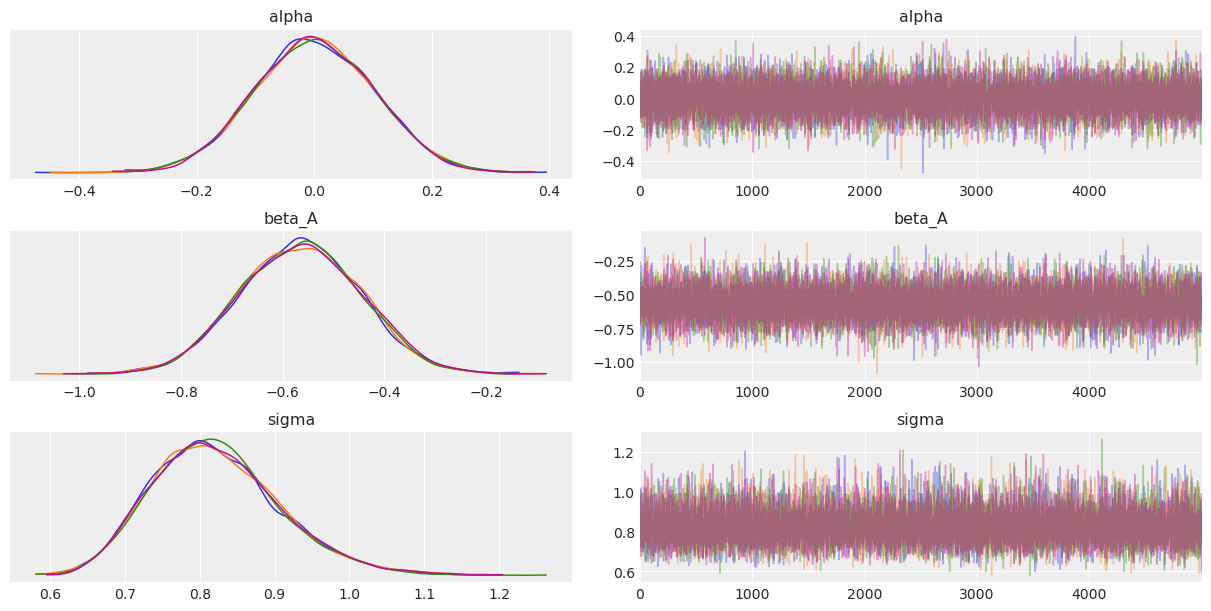

In [8]:
az.plot_trace(trace_5_1, var_names=['alpha', 'beta_A', 'sigma'])

plt.show()

In [9]:
df_tr_5_1 = pm.trace_to_dataframe(trace_5_1)
df_tr_5_1.head()

,alpha,beta_A,sigma,mu__0,mu__1,mu__2,mu__3,mu__4,mu__5,mu__6,...,mu__40,mu__41,mu__42,mu__43,mu__44,mu__45,mu__46,mu__47,mu__48,mu__49
0,0.007105,-0.419476,0.962656,0.261429,0.295159,0.092780,0.598729,-0.244520,0.126510,-0.514360,...,0.160239,0.295159,0.295159,0.936029,-0.278250,-0.109600,0.059050,0.362619,-0.075870,0.632459
1,-0.106986,-0.716476,0.761444,0.327406,0.385018,0.039348,0.903522,-0.536768,0.096960,-0.997661,...,0.154571,0.385018,0.385018,1.479639,-0.594380,-0.306322,-0.018264,0.500241,-0.248710,0.961134
2,-0.039679,-0.329864,0.999886,0.160314,0.186838,0.027693,0.425556,-0.237550,0.054217,-0.449744,...,0.080741,0.186838,0.186838,0.690799,-0.264074,-0.131453,0.001168,0.239887,-0.104929,0.452081
3,-0.035977,-0.259582,0.974754,0.121405,0.142278,0.017040,0.330134,-0.191689,0.037913,-0.358672,...,0.058786,0.142278,0.142278,0.538864,-0.212562,-0.108197,-0.003833,0.184024,-0.087324,0.351007
4,-0.030786,-0.318308,0.819863,0.162201,0.187796,0.034225,0.418152,-0.221726,0.059820,-0.426486,...,0.085416,0.187796,0.187796,0.674103,-0.247321,-0.119345,0.008630,0.238986,-0.093750,0.443747


In [10]:
df_mu_5_1 = df_tr_5_1.filter(regex=('mu.*'))
mu_mean = df_mu_5_1.apply(np.mean, axis=0)

In [11]:
mu_mean.values.shape

(50,)

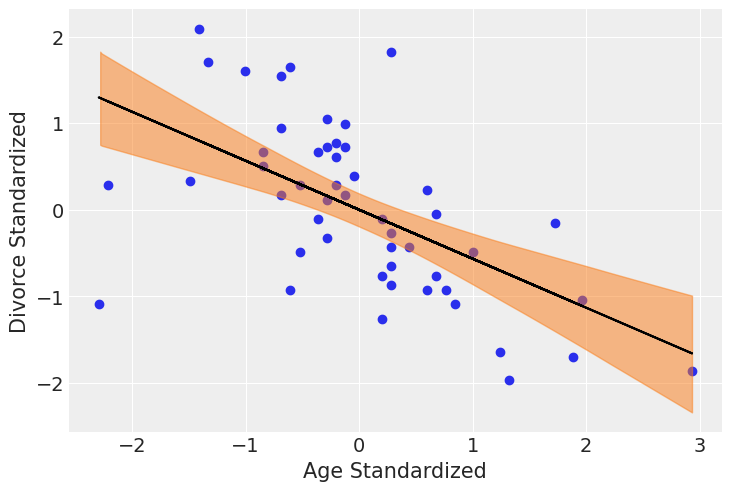

In [12]:
_, ax = plt.subplots(1, 1)
ax.scatter(age, divorce, marker='o')

ax.plot(age, mu_mean, 'k')

az.plot_hdi(age, np.expand_dims(df_mu_5_1.values, 0), ax=ax)

ax.set_xlabel('Age Standardized')
ax.set_ylabel('Divorce Standardized')

plt.show()

## Prior Predictive Plots

### Code 5.4

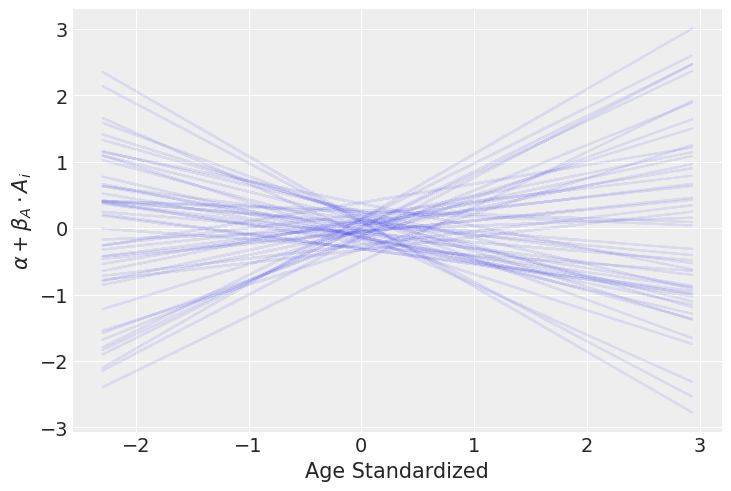

In [13]:
from scipy.stats import norm


N = 50 
alpha_vals = norm.rvs(loc=0, scale=0.2, size=N)
beta_vals = norm.rvs(loc=0, scale=0.5, size=N)

_, ax = plt.subplots(1, 1)
ax.set_xlabel('Age Standardized')
ax.set_ylabel(r'$\alpha + \beta_A \cdot A_i$')

for i in range(N):
    alpha_i = alpha_vals[i]
    beta_i = beta_vals[i]
    
    mu_values = [alpha_i + beta_i * a for a in age]
    
    ax.plot(age, mu_values, color='C0', alpha=0.1)

plt.show()

## Posterior Plots

Since PyMC3 already includes the posterior samples in the trace, we really don't have to do anything more.

### Code 5.5

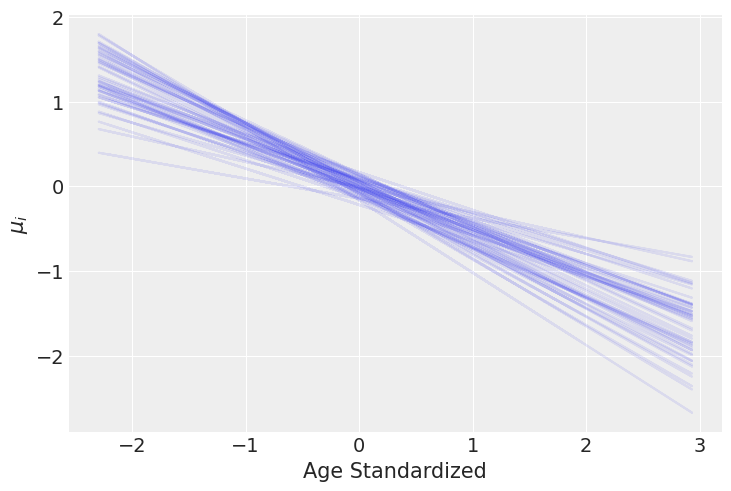

In [14]:
df_mu_T = df_mu_5_1.T

sample = np.random.choice(range(0, 20000), size=50)

_, ax = plt.subplots(1, 1)
ax.plot(age, df_mu_T.loc[:, sample], color='C0', alpha=0.1)

ax.set_xlabel('Age Standardized')
ax.set_ylabel(r'$\mu_i$')

plt.show()

## The Model: Divorce Rate vs Marriage Rate

$$
\begin{align*}
    D_i     & \sim N(\mu_i, \sigma) \\
    \mu_i   & \sim \alpha + \beta_M \cdot M_i \\
    \alpha  & \sim N(0, 0.2) \\
    \beta_M & \sim N(0, 0.5) \\
    \sigma  & \sim \text{Exponential}(1)
\end{align*}
$$

### Code 5.6

In [15]:
with pm.Model() as m_5_2:
    alpha = pm.Normal('alpha', mu=0.0, sigma=0.2)
    beta_M = pm.Normal('beta_M', mu=0.0, sigma=0.5)
    sigma = pm.Exponential('sigma', lam=1)
    
    mu = pm.Deterministic('mu', alpha + beta_M * marriage)
    D_2 = pm.Normal('divorce', mu=mu, sigma=sigma, observed=divorce)
    
    trace_5_2 = pm.sample(5000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_M, alpha]


Sampling 4 chains for 2_000 tune and 5_000 draw iterations (8_000 + 20_000 draws total) took 8 seconds.


/home/somnath/install/anaconda3/envs/stat-rethink-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


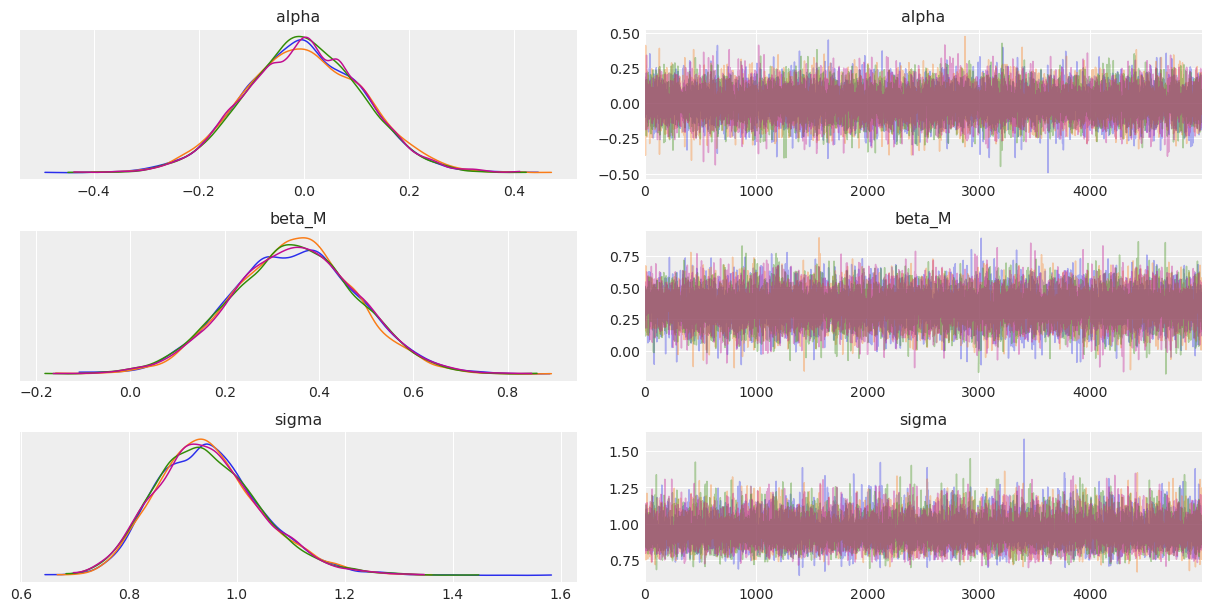

In [16]:
az.plot_trace(trace_5_2, var_names=['alpha', 'beta_M', 'sigma'])

plt.show()

In [17]:
df_tr_5_2 = pm.trace_to_dataframe(trace_5_2)
df_mu_2 = df_tr_5_2.filter(regex='(mu.*)')

df_mu_2.head()

,mu__0,mu__1,mu__2,mu__3,mu__4,mu__5,mu__6,mu__7,mu__8,mu__9,...,mu__40,mu__41,mu__42,mu__43,mu__44,mu__45,mu__46,mu__47,mu__48,mu__49
0,0.115165,0.776966,0.126575,0.822607,-0.010349,0.491707,-0.238556,0.446065,-0.170094,-0.249967,...,0.103754,0.023882,0.263499,1.187738,-0.318429,0.149396,0.252089,0.343372,-0.227146,1.313252
1,-0.070571,0.515986,-0.060458,0.556438,-0.181814,0.263160,-0.384075,0.222708,-0.323397,-0.394188,...,-0.080684,-0.151475,0.060899,0.880055,-0.454866,-0.040231,0.050786,0.131690,-0.373962,0.991298
2,0.131321,0.531207,0.138216,0.558786,0.055480,0.358842,-0.082411,0.331264,-0.041044,-0.089306,...,0.124426,0.076164,0.220951,0.779413,-0.130674,0.152005,0.214056,0.269213,-0.075517,0.855253
3,0.080581,0.864410,0.094096,0.918467,-0.068076,0.526553,-0.338361,0.472496,-0.257276,-0.351876,...,0.067067,-0.027533,0.256267,1.350924,-0.432961,0.121124,0.242753,0.350867,-0.324847,1.499581
4,-0.092340,0.495907,-0.082198,0.536476,-0.203904,0.242352,-0.406748,0.201784,-0.345895,-0.416890,...,-0.102482,-0.173477,0.039509,0.861026,-0.477743,-0.061913,0.029366,0.110504,-0.396605,0.972590


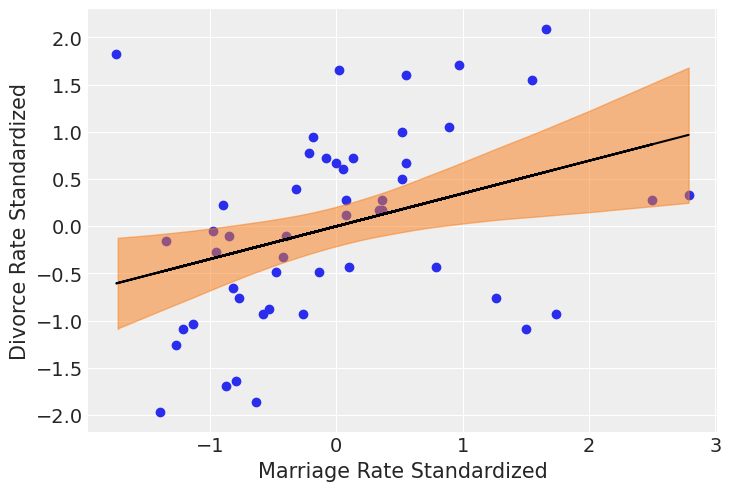

In [18]:
mu_mean_2 = df_mu_2.apply(np.mean, axis=0)

_, ax = plt.subplots(1, 1)
ax.scatter(marriage, divorce, marker='o')

ax.plot(marriage, mu_mean_2, 'k')

az.plot_hdi(marriage, np.expand_dims(df_mu_2.values, 0), ax=ax)

ax.set_xlabel('Marriage Rate Standardized')
ax.set_ylabel('Divorce Rate Standardized')

plt.show()

## Causal Graphs

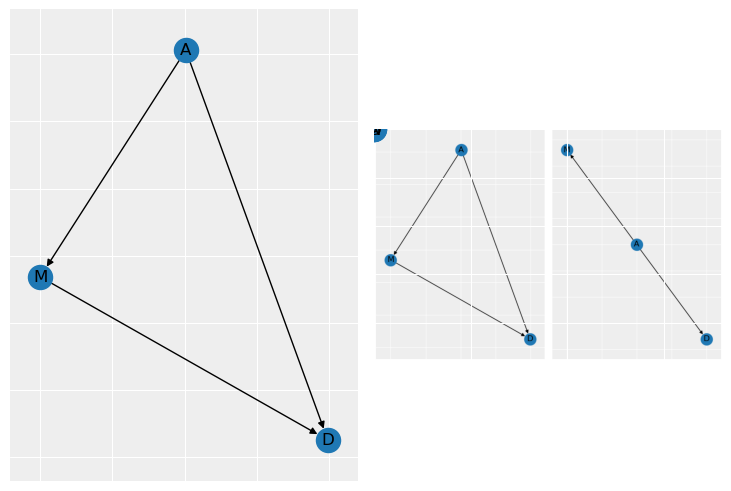

In [19]:
import networkx as nx
import matplotlib.image as mpimg


_, (ax1, ax2) = plt.subplots(1, 2)
g1 = nx.DiGraph()
g2 = nx.DiGraph()

g1.add_edges_from([('A', 'M'), ('A', 'D'), ('M', 'D')])
g2.add_edges_from([('A', 'M'), ('A', 'D')])

#plt.tight_layout()

nx.draw_networkx(g1, arrows=True, ax=ax1)
nx.draw_networkx(g2, arrows=True, ax=ax2)

plt.savefig('DAG1.png', format='PNG')

img = mpimg.imread('DAG1.png')
plt.imshow(img)

## Conditional Independence

In [20]:
df_waf['age_stan'] = (df_waf['MedianAgeMarriage'] - df_waf['MedianAgeMarriage'].mean()) / df_waf['MedianAgeMarriage'].std()
df_waf['divorce_stan'] = (df_waf['Divorce'] - df_waf['Divorce'].mean()) / df_waf['Divorce'].std()
df_waf['marriage_stan'] = (df_waf['Marriage'] - df_waf['Marriage'].mean()) /df_waf['Marriage'].std()

In [21]:
df_waf[['age_stan', 'marriage_stan', 'divorce_stan']].cov()

,age_stan,marriage_stan,divorce_stan
age_stan,1.000000,-0.721096,-0.597239
marriage_stan,-0.721096,1.000000,0.373731
divorce_stan,-0.597239,0.373731,1.000000


<AxesSubplot:xlabel='marriage_stan', ylabel='divorce_stan'>

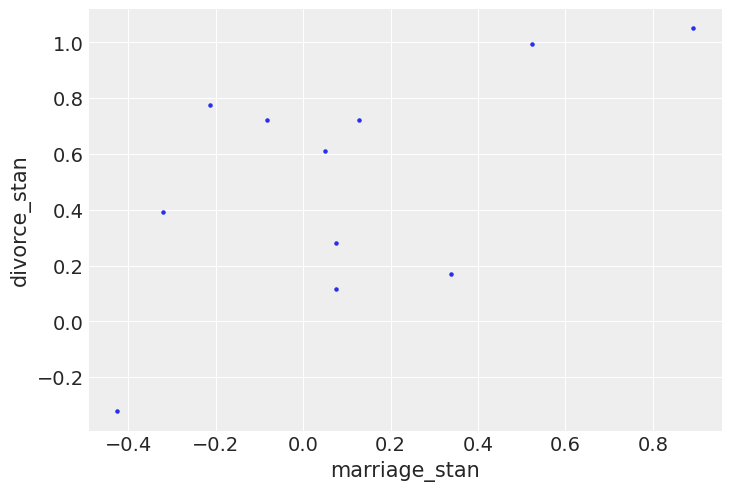

In [22]:
df_waf[(df_waf['age_stan'] >= -0.3) & 
       (df_waf['age_stan'] <= 0.0)][['marriage_stan', 
                                     'divorce_stan']].plot.scatter(x='marriage_stan', 
                                                                   y='divorce_stan', 
                                                                   marker='.')

## Multiple Regression Model

$$
\begin{align*}
    D_i     & \sim N(\mu_i, \sigma) \\
    \mu_i   & \sim \alpha + \beta_A \cdot A_i + \beta_M \cdot M_i\\
    \alpha  & \sim N(0, 0.2) \\
    \beta_A & \sim N(0, 0.5) \\
    \beta_M & \sim N(0, 0.5) \\
    \sigma  & \sim \text{Exponential}(1)
\end{align*}
$$

### Code 5.10

In [23]:
with pm.Model() as m_5_3:
    alpha = pm.Normal('alpha', mu=0.0, sigma=0.2)
    beta_A = pm.Normal('beta_A', mu=0.0, sigma=0.5)
    beta_M = pm.Normal('beta_M', mu=0.0, sigma=0.5)
    sigma = pm.Exponential('sigma', lam=1.0)
    
    mu = pm.Deterministic('mu', alpha + beta_A * df_waf['age_stan'] + beta_M * df_waf['marriage_stan'])
    D = pm.Normal('divorce', mu=mu, sigma=sigma, observed=df_waf['divorce_stan'])
    
    trace_5_3 = pm.sample(5000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_M, beta_A, alpha]


Sampling 4 chains for 2_000 tune and 5_000 draw iterations (8_000 + 20_000 draws total) took 13 seconds.


In [24]:
az.summary(trace_5_3, var_names=['alpha', 'beta_A', 'beta_M', 'sigma'], hdi_prob=0.89)

/home/somnath/install/anaconda3/envs/stat-rethink-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,-0.001,0.102,-0.161,0.166,0.001,0.001,14282.0,9428.0,14293.0,11544.0,1.0
beta_A,-0.608,0.158,-0.866,-0.365,0.002,0.001,10652.0,10521.0,10646.0,12565.0,1.0
beta_M,-0.062,0.158,-0.324,0.183,0.002,0.001,11081.0,11081.0,11077.0,13426.0,1.0
sigma,0.826,0.086,0.686,0.955,0.001,0.001,14634.0,14634.0,14029.0,9749.0,1.0


In [25]:
df_tr_5_3 = pm.trace_to_dataframe(trace_5_3)
df_tr_5_3.head()

,alpha,beta_A,beta_M,sigma,mu__0,mu__1,mu__2,mu__3,mu__4,mu__5,...,mu__40,mu__41,mu__42,mu__43,mu__44,mu__45,mu__46,mu__47,mu__48,mu__49
0,0.053574,-0.395616,0.094113,0.868883,0.295563,0.471099,0.138984,0.767314,-0.208866,0.250092,...,0.197651,0.307550,0.359588,1.164724,-0.307584,-0.046928,0.134431,0.440557,-0.096892,0.905680
1,0.062833,-0.534761,0.099515,0.854222,0.389306,0.584281,0.176926,0.981763,-0.284517,0.303775,...,0.257686,0.411344,0.466370,1.495612,-0.398264,-0.075833,0.162749,0.570712,-0.119302,1.137434
2,-0.001483,-0.896953,-0.216384,0.832311,0.537430,0.279101,0.171114,0.905425,-0.481753,0.060919,...,0.326757,0.655134,0.535487,1.444343,-0.400046,-0.273023,0.036318,0.639852,-0.012883,0.732558
3,0.031048,-0.793229,-0.378778,0.799831,0.503397,-0.011272,0.174507,0.522884,-0.343646,-0.080856,...,0.322021,0.646967,0.437527,0.841571,-0.138149,-0.228139,0.001017,0.495281,0.164764,0.157814
4,0.194150,-0.789084,-0.158238,0.929933,0.668980,0.490776,0.347564,1.045161,-0.236939,0.277687,...,0.482797,0.765762,0.678267,1.546334,-0.187895,-0.041469,0.238283,0.776001,0.159474,0.929453


## Comparison of the $\beta_M$ and $\beta_A$ values from three models

In [26]:
summary_1 = az.summary(trace_5_1, var_names=['alpha', 'beta_A', 'sigma'], hdi_prob=0.89)
summary_2 = az.summary(trace_5_2, var_names=['alpha', 'beta_M', 'sigma'], hdi_prob=0.89)
summary_3 = az.summary(trace_5_3, var_names=['alpha', 'beta_A', 'beta_M', 'sigma'], hdi_prob=0.89)

/home/somnath/install/anaconda3/envs/stat-rethink-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/somnath/install/anaconda3/envs/stat-rethink-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/somnath/install/anaconda3/envs/stat-rethink-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less 

In [27]:
type(summary_1)

pandas.core.frame.DataFrame

In [28]:
summary_1.loc['beta_A', :]

mean            -0.566
sd               0.119
hdi_5.5%        -0.749
hdi_94.5%       -0.374
mcse_mean        0.001
mcse_sd          0.001
ess_mean     26689.000
ess_sd       25484.000
ess_bulk     26680.000
ess_tail     14896.000
r_hat            1.000
Name: beta_A, dtype: float64

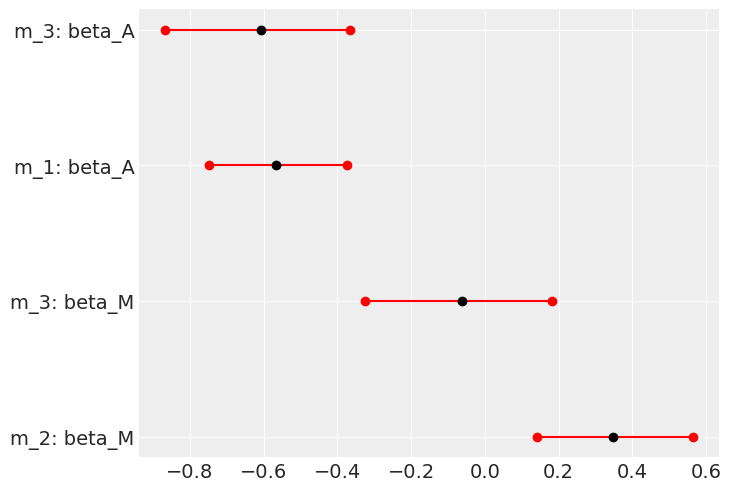

In [29]:
# Do the plots manually!

summary_list = [(summary_2, 'beta_M', 1), 
                (summary_3, 'beta_M', 2), 
                (summary_1, 'beta_A', 3),  
                (summary_3, 'beta_A', 4)]

_, ax = plt.subplots(1, 1)


for summary, var, y_level in summary_list:
    lower = summary.loc[var, 'hdi_5.5%']
    upper = summary.loc[var, 'hdi_94.5%']
    mid = summary.loc[var, 'mean']

    ax.plot((lower, upper), (y_level, y_level), 'ro-')
    ax.plot((mid), (y_level), 'ko')

plt.yticks([1, 2, 3, 4], ['m_2: beta_M', 'm_3: beta_M', 'm_1: beta_A', 'm_3: beta_A'])

plt.show()